# ML Models: Data Loading + Sanitation

This notebook loads the MoCA/SATURN dataset and applies basic sanitation to prepare it for statistical analysis and ML models.

- Handles "NA" strings and empty values
- Strips whitespace
- Coerces numeric-like columns based on column-name patterns
- Produces a quick missingness summary


## 1) Imports + Paths
Adjust `DATA_PATH` if you want to target a different file (e.g., `data/SATURN_MoCA.csv`).

In [167]:
from pathlib import Path
import re
import pandas as pd
import numpy as np

ROOT = Path('..').resolve()
DATA_PATH = ROOT / 'data' / 'MoCA' / 'SATURN_MoCA.csv'

DATA_PATH.exists(), DATA_PATH

(True,
 WindowsPath('C:/Users/sarin/Documents/GitHub/memory-lane/data/MoCA/SATURN_MoCA.csv'))

In [168]:
na_values = ['', 'NA', 'Na', 'na', 'N/A', 'NULL', 'null', 'nan']
df_raw = pd.read_csv(DATA_PATH, encoding="cp1252", na_values=na_values, dtype=str, low_memory=False)
df_raw.shape

(1033, 192)

## 3) Sanitation Helpers

In [169]:
NUMERIC_PATTERNS = [
    r'_SCORE$', r'_TOTAL_SCORE$', r'_POSSIBLE_SCORE$', r'_POINTS$',
    r'_TIME_SINCE_INDEX_days$', r'_ms$', r'_min$', r'_days$', r'_COUNT',
    r'_SPEED', r'_TOTAL$', r'_WORDS_GENERATED', r'_MIS'
]
NUMERIC_REGEX = re.compile('(' + '|'.join(NUMERIC_PATTERNS) + ')')

def _clean_string_series(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip().replace({'': np.nan})

def sanitize_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # Strip whitespace in all object columns
    for col in out.columns:
        out[col] = _clean_string_series(out[col])

    # Coerce numeric-like columns based on patterns
    for col in out.columns:
        if NUMERIC_REGEX.search(col):
            out[col] = pd.to_numeric(out[col], errors='coerce')

    return out

df = sanitize_dataframe(df_raw)
df.shape

(1033, 192)

## 7) Mixed Population Strategy (General Info + Test Outcomes)
Keep all rows, add missingness flags for tests, and optionally build a test-only subset.

In [170]:
# Convert YR_EDU bins to numeric midpoint
import numpy as np

def edu_bin_to_num(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip().lower()
    if s == 'under_12':
        return 11.0
    if s == '20_or_more':
        return 20.0
    if '_' in s:
        a, b = s.split('_', 1)
        try:
            return (float(a) + float(b)) / 2.0
        except ValueError:
            return np.nan
    return np.nan

df['YR_EDU_num'] = df['YR_EDU'].apply(edu_bin_to_num)


C:\Users\sarin\AppData\Local\Temp\ipykernel_27708\513788860.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['YR_EDU_num'] = df['YR_EDU'].apply(edu_bin_to_num)


In [171]:
missing = (df.isna().mean() * 100).sort_values(ascending=False)
missing.head(20)

SLUMS_2_COUNT_animals_named_in_60s    98.063892
SLUMS_2_TOTAL_SCORE                   97.870281
SLUMS_2_POSSIBLE_SCORE                97.870281
SLUMS_2_TIME_SINCE_INDEX_days         97.870281
MoCA_2_MIS                            94.772507
MoCA_2_WORDS_GENERATED                94.288480
SATURN_TIME_MINI_TRAILS_B_ms          93.804453
SATURN_TIME_MINI_TRAILS_A_ms          93.126815
HIDE4_TIME_SINCE_INDEX_days           92.642788
SATURN_TIME_STROOP_MEAN_ms            92.061955
SATURN_SCORE_STROOP_POINTS            92.061955
MoCA_2_TIME_SINCE_INDEX_days          91.965150
MoCA_2_TOTAL_SCORE                    91.965150
MoCA_2_POSSIBLE_SCORE                 91.965150
MMSE_2_POSSIBLE_SCORE                 91.287512
MMSE_2_TOTAL_SCORE                    91.287512
MMSE_2_TIME_SINCE_INDEX_days          91.287512
SATURN_TIME_SPATIAL_2_ms              89.351404
SATURN_TIME_SPATIAL_3_ms              89.351404
SATURN_TIME_SPATIAL_4_ms              89.254598
dtype: float64

In [172]:
df["INDEX_EVENT"].value_counts(dropna=False)

INDEX_EVENT
nan       469
MoCA      150
MMSE      150
SATURN    149
SLUMS     112
MOCA        3
Name: count, dtype: int64

If you want a binary label (normal vs abnormal), map `GENERAL_Dx` like: 
- NORMAL -> 0
- MCI or DEMENTIA -> 1
- OTHER -> drop or map separately

In [173]:
# Example flags for whether key tests exist
df = df.copy()
df["INDEX_EVENT"] = (
    df["INDEX_EVENT"]
      .astype(str)
      .str.strip()
      .str.upper()
      .replace({"NA": np.nan, "N/A": np.nan, "NAN": np.nan, "NONE": np.nan, "": np.nan})
)

idx = df["INDEX_EVENT"]
df["INDEX_EVENT"] = df["INDEX_EVENT"].replace({"NA": np.nan, "nan": np.nan, "None": np.nan})

df['has_index_event'] = df['INDEX_EVENT'].notna()

df["has_moca"] = idx.eq("MOCA")
df["has_saturn"] = idx.eq("SATURN")
df["has_mmse"] = idx.eq("MMSE")
df["has_slums"] = idx.eq("SLUMS")


df[['has_index_event','has_moca','has_saturn','has_mmse','has_slums']].mean().sort_values(ascending=False)

df_saturn = df[df['has_saturn']]
df_test = (df_saturn.isna().mean() * 100).sort_values(ascending=True).to_frame()


## 16) Correlation Matrix
Computes correlation for numeric features only.

In [174]:
# 16) Correlation matrix for numeric features
numeric_df = df.select_dtypes(include=['number']).copy()

# Optionally drop id-like columns
for col in ['PATIENT']:
    if col in numeric_df.columns:
        numeric_df = numeric_df.drop(columns=[col])

corr = numeric_df.corr()


### Correlation Heatmap (matplotlib)

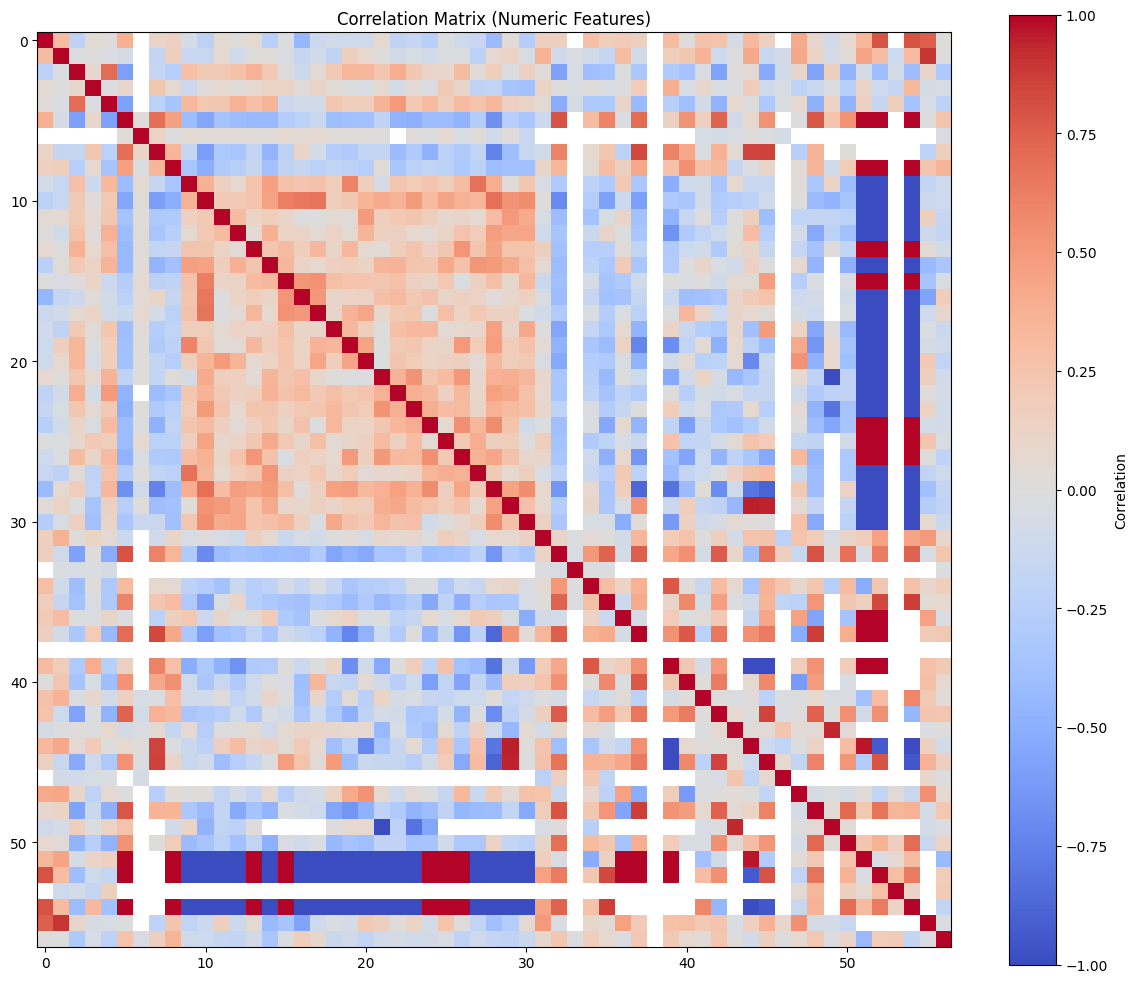

In [175]:
# 16b) Correlation heatmap (matplotlib)
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 10))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix (Numeric Features)')
plt.tight_layout()
plt.show()


### Top Correlated Feature Pairs

In [176]:
# 16c) Top correlated feature pairs (absolute)
# Flatten correlation matrix, drop self-correlation and duplicates
corr_abs = corr.abs()

pairs = (
    corr_abs.where(~np.eye(corr_abs.shape[0], dtype=bool))
            .stack()
            .sort_values(ascending=False)
)

# Remove duplicate pairs (A,B) vs (B,A)
seen = set()
unique_pairs = []
for (a, b), val in pairs.items():
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    unique_pairs.append((a, b, val))

pd.DataFrame(unique_pairs, columns=['feature_1', 'feature_2', 'abs_corr']).head(10)


,feature_1,feature_2,abs_corr
0,SATURN_TIME_INCIDENTAL_MEMORY_J_ms,SLUMS_2_COUNT_animals_named_in_60s,1.0
1,SATURN_TIME_INCIDENTAL_MEMORY_J_ms,SLUMS_2_TOTAL_SCORE,1.0
2,SATURN_TIME_INCIDENTAL_MEMORY_J_ms,SLUMS_2_TIME_SINCE_INDEX_days,1.0
3,SLUMS_2_TOTAL_SCORE,SATURN_TIME_STROOP_MEAN_ms,1.0
4,SLUMS_2_TOTAL_SCORE,SATURN_TIME_MATH_SUBTRACT_ms,1.0
5,SLUMS_2_TOTAL_SCORE,SATURN_TIME_MATH_ADD_ms,1.0
6,SLUMS_2_TOTAL_SCORE,SATURN_TIME_RECALL_FIVEWORDS_ms,1.0
7,SLUMS_2_TOTAL_SCORE,SATURN_TIME_INCIDENTAL_MEMORY_NUMBER_ms,1.0
8,SLUMS_2_TOTAL_SCORE,SATURN_TIME_INCIDENTAL_MEMORY_PHRASE_ms,1.0
9,SLUMS_2_TOTAL_SCORE,SATURN_TIME_ORIENTATION_STATE_ms,1.0


## Unified Preprocessing (Shared for All Models)
Builds features, labels, missingness flags, and a single preprocessing pipeline.

In [177]:
# Unified preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd

label_map = {'NORMAL': 0, 'MCI': 1, 'DEMENTIA': 1}

y = df['GENERAL_Dx'].map(label_map)
mask = y.notna()

feature_cols = [
    'AGE', 'AUTO_LEGAL_SEX', 'RACE_ETHNICITY', 'YR_EDU_num',
    'SATURN_SCORE_STROOP_POINTS', 'SATURN_TIME_STROOP_ERRORS', 'SATURN_TIME_STROOP_MEAN_ms',
    'MoCA_1_SCORE_orientation', 'SATURN_SCORE_ORIENTATION_MONTH', 'SATURN_SCORE_ORIENTATION_YEAR',
    'SATURN_SCORE_ORIENTATION_DAY_OF_WEEK', 'SATURN_SCORE_ORIENTATION_STATE',
    'SATURN_SCORE_RECALL_FIVEWORDS', 'SATURN_TIME_RECALL_FIVEWORDS_ms', 'MoCA_1_SCORE_recall',
    'SATURN_MOTOR_SPEED_ms_per_button'
]

existing_features = [c for c in feature_cols if c in df.columns]
X = df.loc[mask, existing_features].copy()
y = y.loc[mask]

# Missingness indicators
for col in existing_features:
    X[f'{col}_missing'] = X[col].isna().astype(int)

numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, numeric_cols),
        ('cat', categorical_pipe, categorical_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Train and Compare Models
Trains Logistic Regression, Decision Tree, Random Forest, and XGBoost (if available).

In [178]:
# Train and compare models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd

models = {
    'log_reg': LogisticRegression(max_iter=300, class_weight='balanced'),
    'decision_tree': DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced'),
    'random_forest': RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
}

try:
    from xgboost import XGBClassifier
    models['xgboost'] = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric='logloss',
        random_state=42
    )
except Exception as e:
    print('XGBoost not available:', e)

rows = []
for name, clf in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocess), ('clf', clf)])
    pipe.fit(X_train, y_train)

    train_pred = pipe.predict(X_train)
    test_pred = pipe.predict(X_test)
    test_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['clf'], 'predict_proba') else None

    row = {
        'model': name,
        'train_accuracy': accuracy_score(y_train, train_pred),
        'test_accuracy': accuracy_score(y_test, test_pred),
        'f1': f1_score(y_test, test_pred)
    }
    if test_proba is not None:
        row['roc_auc'] = roc_auc_score(y_test, test_proba)

    rows.append(row)

results_df = pd.DataFrame(rows).sort_values(by='f1', ascending=False)
results_df


,model,train_accuracy,test_accuracy,f1,roc_auc
3,xgboost,0.924406,0.905172,0.941176,0.884058
1,decision_tree,0.870410,0.844828,0.901099,0.784873
2,random_forest,0.956803,0.827586,0.888889,0.866168
0,log_reg,0.831533,0.775862,0.847059,0.868659


### Comparison Plot (End)

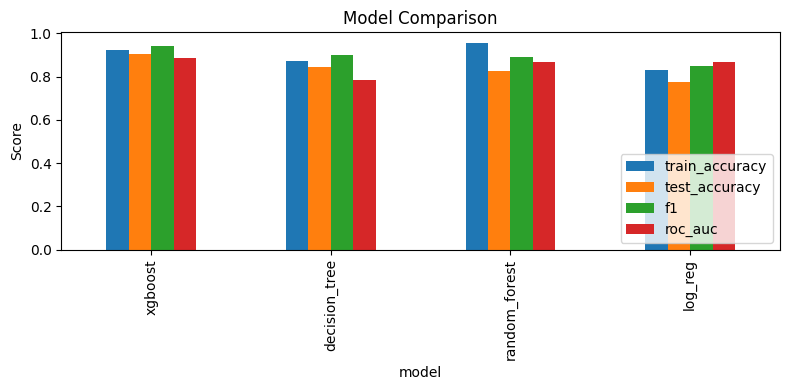

In [179]:
# Comparison plot at the end
import matplotlib.pyplot as plt

# Expect results_df from model comparison block
metrics = ['train_accuracy', 'test_accuracy', 'f1']
if 'roc_auc' in results_df.columns:
    metrics.append('roc_auc')

ax = results_df.set_index('model')[metrics].plot(kind='bar', figsize=(8, 4))
ax.set_ylabel('Score')
ax.set_title('Model Comparison')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()


### Results Table (Train/Test Accuracy)


In [180]:
# Results table
cols = ['model', 'train_accuracy', 'test_accuracy', 'f1']
if 'roc_auc' in results_df.columns:
    cols.append('roc_auc')

results_df[cols]


,model,train_accuracy,test_accuracy,f1,roc_auc
3,xgboost,0.924406,0.905172,0.941176,0.884058
1,decision_tree,0.870410,0.844828,0.901099,0.784873
2,random_forest,0.956803,0.827586,0.888889,0.866168
0,log_reg,0.831533,0.775862,0.847059,0.868659


### Export Best Model
Exports the best model (by F1) as a joblib file for Flask use.

In [181]:
# Export best model
import joblib
from pathlib import Path

best_name = results_df.sort_values(by='f1', ascending=False).iloc[0]['model']

# Recreate the chosen model
if best_name == 'log_reg':
    best_clf = LogisticRegression(max_iter=300, class_weight='balanced')
elif best_name == 'decision_tree':
    best_clf = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
elif best_name == 'random_forest':
    best_clf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
elif best_name == 'xgboost':
    from xgboost import XGBClassifier
    best_clf = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric='logloss',
        random_state=42
    )
else:
    raise ValueError(f'Unknown model: {best_name}')

best_model = Pipeline(steps=[('preprocess', preprocess), ('clf', best_clf)])
best_model.fit(X, y)

out_path = Path('..') / 'ml-models' / 'best_model.joblib'
joblib.dump(best_model, out_path)
out_path


WindowsPath('../ml-models/best_model.joblib')